In [1]:
import os, sys, ROOT
import uproot as np                                                    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Welcome to JupyROOT 6.08/06


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data.dataloader as dataloader

from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

from mpid_data import mpid_data
from mpid_net import mpid_net, mpid_func

In [3]:
from lib.config import config_loader
CFG = os.path.join("../../cfg","inference_config.cfg")
cfg  = config_loader(CFG)

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=cfg.GPUID

self.adc_lo=float(10)
self.adc_hi=float(500)
self.augment=False
self.batch_size_train=int(1)
self.batch_size_test=int(1)
self.drop_out=0.0
self.EPOCHS=50
self.GPUID=str("1")
self.learning_rate=float(1e-3)
self.name=str("BN_False_LR-3_AG_True")
self.num_class=int(5)
self.plane=2
self.run_test=True
self.test_events_nums=9
self.test_every_step=10
self.weight_file_mpid_0=str("/scratch/ruian/training_data/weights/pid/plane0/pid-245199")
self.weight_file_mpid_1=str("/scratch/ruian/training_data/weights/pid/plane1/pid-355199")
self.weight_file_mpid_2=str("/scratch/ruian/training_data/weights/pid/plane2/pid-453799")
self.xdim=int(512)
self.ydim=int(512)


In [4]:
weight_file="../../weight/mpid_model_20191108-12_41_AM_epoch_29_batch_id_1811_title_LR-3_AG_True_new_modi_GN_changes_in_fullyCY_step_55954.pwf"

In [5]:
train_device = 'cuda' if torch.cuda.is_available() else 'cpu'

mpid = mpid_net.MPID()
mpid.cuda()

mpid.load_state_dict(torch.load(weight_file, map_location=train_device))

mpid.eval()

MPID(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): GroupNorm(64, 64, eps=1e-05, affine=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): GroupNorm(64, 64, eps=1e-05, affine=True)
    (6): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (7): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): GroupNorm(96, 96, eps=1e-05, affine=True)
    (10): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): GroupNorm(96, 96, eps=1e-05, affine=True)
    (13): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (14): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): GroupNorm(128, 128, eps=1e-05, affine=True)
    (17): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (18): ReLU()
    (19): GroupNorm(128, 128, eps=1e-05, affine=True)
    (20): AvgPool2d(kernel_size=2, str

In [6]:
# test_file = "./input/1e.root"
test_file = "./input/1e1p1gamma.root"
# test_file = "./input/1mu1p.root"
# test_file = "./input/1pion1p.root"
# test_file = "./input/1gamma1p.root"
# test_file = "./input/1gamma.root"
# test_file = "./input/1gamma1p.root"
# test_file = "./input/1mu1pion.root"

test_data = mpid_data.MPID_Dataset(test_file, "particle_mctruth_tree", "sparse2d_wire_tree", train_device)
test_loader = DataLoader(dataset=test_data, batch_size= 1 , shuffle=True)


Warning in <TClass::Init>: no dictionary for class ROOT::TIOFeatures is available


In [7]:
def add_mask(input_tensor):
    input_tensor[input_tensor>0] = 0 
    return input_tensor

In [8]:
#1e1p, entry 30 42 45

# Scanning Occlusion

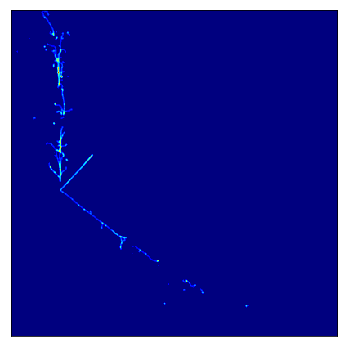

In [17]:
occlusion_step = 4
# do_occlusion = False
do_occlusion = True
entry_start=32
entries=1
if not do_occlusion:
    entries = 10

for ENTRY in xrange(entry_start, entry_start + entries):
    input_image = test_data[ENTRY][0].view(-1,1,512,512)

    input_image[0][0][input_image[0][0] > 500] = 500
    input_image[0][0][input_image[0][0] < 10 ] = 0
    
#     print np.max(input_image.cpu().detach().numpy())

    engs = test_data[ENTRY][2].cpu().detach().numpy()

    score = nn.Sigmoid()(mpid(input_image.cuda()))
    
#     print score.cpu().detach().numpy()[0]
    
    fig, ax= plt.subplots(1,1,figsize=(7,6))
    ax.imshow(input_image.cpu()[0][0], cmap='jet')
    ax.set_xlim(100,500)
    ax.set_ylim(100,500)
    ax.tick_params(top=0, bottom=0, left=0, right=0, labelleft=0, labelbottom=0)

#     ax.text(0,20, "elec, %.3f"%score.cpu().detach().numpy()[0][0],color="white",fontsize=15)
#     ax.text(0,40, "gamm, %.3f"%score.cpu().detach().numpy()[0][1],color="white",fontsize=15)
#     ax.text(0,60, "muon, %.3f"%score.cpu().detach().numpy()[0][2],color="white",fontsize=15)
#     ax.text(0,80, "pion, %.3f"%score.cpu().detach().numpy()[0][3],color="white",fontsize=15)
#     ax.text(0,100, "prot, %.3f"%score.cpu().detach().numpy()[0][4],color="white",fontsize=15)
#     ax.text(0,120, "Entry, %i"%ENTRY,color="white",fontsize=15)
#     ax.text(0,140, "eng elec, %.1f"%(engs[0]*1000),color="white",fontsize=15)
#     ax.text(0,160, "eng gam, %.1f"%(engs[1]*1000),color="white",fontsize=15)
#     ax.text(0,180, "eng muo, %.1f"%(engs[2]*1000),color="white",fontsize=15)
#     ax.text(0,200, "eng pion, %.1f"%(engs[3]*1000),color="white",fontsize=15)
#     ax.text(0,220, "eng prot, %.1f"%(engs[4]*1000-938),color="white",fontsize=15)
    
    if not do_occlusion: continue
    
#     clone_image = input_image.cpu().clone()
#     clone_image[0][0][200:300, 400:430] = 50
#     fig, ax= plt.subplots(1,1,figsize=(10,8))    
#     ax.imshow(clone_image.cpu()[0][0], cmap='jet')
    score_map_elec = np.full([512-occlusion_step, 512-occlusion_step], score.cpu().detach().numpy()[0][0])
    score_map_gamm = np.full([512-occlusion_step, 512-occlusion_step], score.cpu().detach().numpy()[0][1])
    score_map_muon = np.full([512-occlusion_step, 512-occlusion_step], score.cpu().detach().numpy()[0][2])
    score_map_pion = np.full([512-occlusion_step, 512-occlusion_step], score.cpu().detach().numpy()[0][3])
    score_map_prot = np.full([512-occlusion_step, 512-occlusion_step], score.cpu().detach().numpy()[0][4])
    
    clone_image = input_image.cpu().clone()
    
    for x in xrange(512 - occlusion_step):
        for y in xrange(512 - occlusion_step):
            clone_image = input_image.cpu().clone()
#             if np.count_nonzero(clone_image[0][0][x-occlusion_step:x+occlusion_step+1,
#                                                   y-occlusion_step:y+occlusion_step+1])==0:continue
            if clone_image[0][0][x,y]==0:continue
            
            clone_image[0][0][x-occlusion_step:x+occlusion_step+1,
                              y-occlusion_step:y+occlusion_step+1] = torch.zeros([2*occlusion_step+1, 2*occlusion_step+1])
            
            score = nn.Sigmoid()(mpid(clone_image.cuda())).cpu().detach().numpy()[0]
            score_map_elec[x,y] = score[0]
            score_map_gamm[x,y] = score[1]
            score_map_muon[x,y] = score[2]
            score_map_pion[x,y] = score[3]
            score_map_prot[x,y] = score[4]
        
#             fig, ax= plt.subplots(1,1,figsize=(10,8))    
#             ax.imshow(clone_image[0][0], cmap='jet')
#             ax.plot(y, x, "*", color = 'white',markersize=5)
#             ax.text(0,20, score[0],color="white",fontsize=15)
#             ax.text(0,40, score[1],color="white",fontsize=15)
#             ax.text(0,60, score[2],color="white",fontsize=15)
#             ax.text(0,80, score[3],color="white",fontsize=15)
#             ax.text(0,100, score[4],color="white",fontsize=15)

#             ax.text(0,0,"Y Plane", fontsize=20, color="white")
#             ax.text(0, 50, "MicroBooNE Simulation", fontsize=20, color="white")

#     clone_image = input_image.cpu().clone()
# #     clone_image = torch.ones([1,1,512,512])
#     y = 190
#     x = 430
#     clone_image[0][0][x-occlusion_step:x+occlusion_step+1,
#                       y-occlusion_step:y+occlusion_step+1] = torch.zeros([2*occlusion_step+1, 2*occlusion_step+1])
#     score = nn.Sigmoid()(mpid(clone_image.cuda())).cpu().detach().numpy()[0]
#     fig, ax= plt.subplots(1,1,figsize=(10,8))    
#     ax.imshow(clone_image[0][0], cmap='jet')
#     ax.plot(y, x, "*", color = 'white',markersize=5)
#     ax.text(0,20, score[0],color="white",fontsize=15)
#     ax.text(0,40, score[1],color="white",fontsize=15)
#     ax.text(0,60, score[2],color="white",fontsize=15)
#     ax.text(0,80, score[3],color="white",fontsize=15)
#     ax.text(0,100, score[4],color="white",fontsize=15)

In [28]:
def score_plot(score_map, title, xmin, xmax, ymin, ymax, vmin, vmax, cmap="jet"):

    if not xmin:
        xmin=0
        ymin=0
        xmax=score_map.shape[1]-1
        ymax=score_map.shape[1]-1
    
    xmin = 100
    xmax = 500
    ymin = 100
    ymax = 500
    
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    pos = ax.imshow(score_map, cmap=cmap, vmin=vmin, vmax=vmax)     
#     ax.set_title(title)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel("%s score map"%title, fontsize=15)
    fig.colorbar(pos, ax=ax)
    ax.tick_params(top=0, bottom=0, left=0, right=0, labelleft=0, labelbottom=0)

    plt.savefig("/media/hdd1/ruian/work/MPID_pytorch/uboone/occlusion/output/%s_score_map.png"%title,
                bbox_inches="tight", pad_inches=0.01)

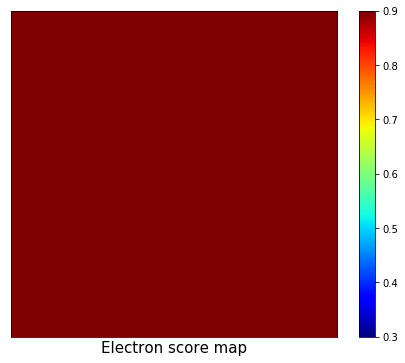

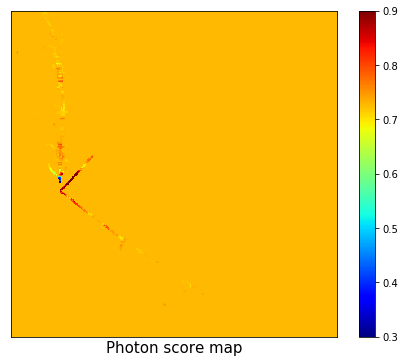

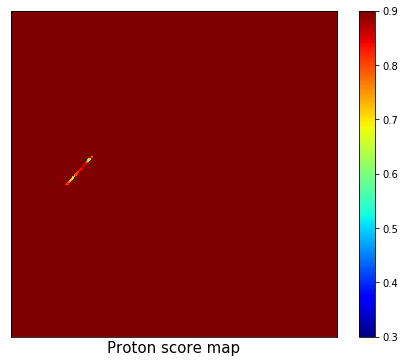

In [29]:
cmap="Oranges"
cmap="jet"
vmin = 0.3
vmax = 0.9
# cmap="Oranges"
score_plot(score_map_elec, "Electron", 0,0,0,0,vmin,vmax, cmap)
score_plot(score_map_gamm, "Photon", 0,0,0,0,vmin,vmax, cmap)
# score_plot(score_map_muon, "muon", 0,0,0,0,vmin,vmax, cmap)
# score_plot(score_map_pion, "pion", 0,0,0,0,vmin,vmax, cmap)
score_plot(score_map_prot, "Proton", 0,0,0,0,vmin,vmax, cmap)

# Box Occlusion

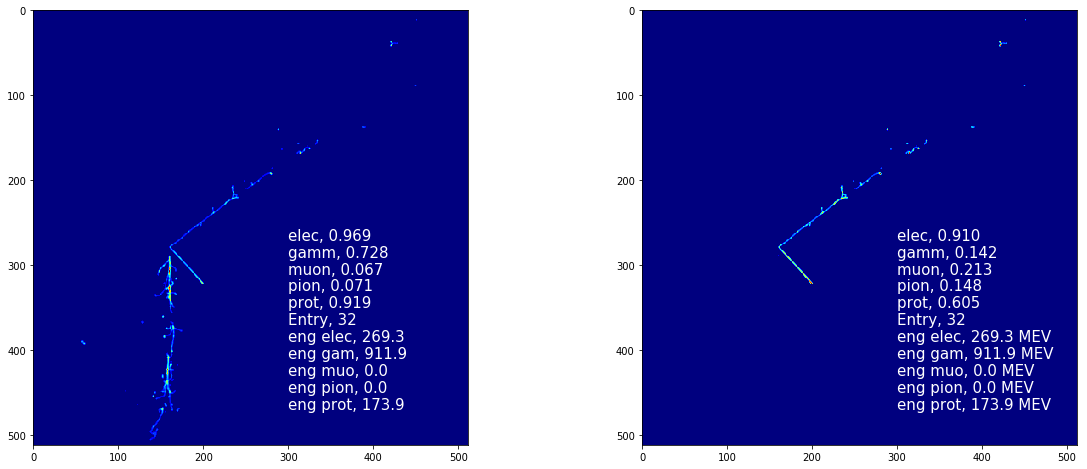

In [67]:
do_occlusion = False
do_occlusion = True
entry_start=32
entries=1
if not do_occlusion:
    entries = 10

for ENTRY in xrange(entry_start, entry_start + entries):
    input_image = test_data[ENTRY][0].view(-1,1,512,512)

#     print np.max(input_image.cpu().detach().numpy())

    engs = test_data[ENTRY][2].cpu().detach().numpy()

    score = nn.Sigmoid()(mpid(input_image.cuda()))
    
#     print score.cpu().detach().numpy()[0]
    
    fig, (ax1,ax2)= plt.subplots(1,2,figsize=(20,8))
    ax1.imshow(input_image.cpu()[0][0], cmap='jet')
#     ax1.set_xlim(0,511)
#     ax1.set_ylim(0,511)
    ybase = 250
    xbase = 300
    ax1.text(xbase+0,ybase+20, "elec, %.3f"%score.cpu().detach().numpy()[0][0],color="white",fontsize=15)
    ax1.text(xbase+0,ybase+40, "gamm, %.3f"%score.cpu().detach().numpy()[0][1],color="white",fontsize=15)
    ax1.text(xbase+0,ybase+60, "muon, %.3f"%score.cpu().detach().numpy()[0][2],color="white",fontsize=15)
    ax1.text(xbase+0,ybase+80, "pion, %.3f"%score.cpu().detach().numpy()[0][3],color="white",fontsize=15)
    ax1.text(xbase+0,ybase+100, "prot, %.3f"%score.cpu().detach().numpy()[0][4],color="white",fontsize=15)
    ax1.text(xbase+0,ybase+120, "Entry, %i"%ENTRY,color="white",fontsize=15)
    ax1.text(xbase+0,ybase+140, "eng elec, %.1f"%(engs[0]*1000),color="white",fontsize=15)
    ax1.text(xbase+0,ybase+160, "eng gam, %.1f"%(engs[1]*1000),color="white",fontsize=15)
    ax1.text(xbase+0,ybase+180, "eng muo, %.1f"%(engs[2]*1000),color="white",fontsize=15)
    ax1.text(xbase+0,ybase+200, "eng pion, %.1f"%(engs[3]*1000),color="white",fontsize=15)
    ax1.text(xbase+0,ybase+220, "eng prot, %.1f"%(engs[4]*1000-938),color="white",fontsize=15)
    
    clone_image = input_image.cpu().clone()       
    clone_image[0][0][clone_image[0][0] > 500] = 500
    clone_image[0][0][clone_image[0][0] < 10 ] = 0
    ########################################
#     clone_image[0][0][290:310, 150:170] = 0  #1e1p1gamma entry32
#     clone_image[0][0][200:279, 160:210] = 0 # prton
#     clone_image[0][0][310:350, 170:210] = 0 # proton
    clone_image[0][0][290:, :170] = 0 # proton
    clone_image[0][0][350:, :190] = 0 # proton

    ########################################    
    ax2.imshow(clone_image[0][0], cmap='jet')
#     ax2.set_xlim(0,511)
#     ax2.set_ylim(0,511)
    score = nn.Sigmoid()(mpid(clone_image.cuda()))#.cpu().detach().numpy()[0]
    ax2.text(xbase+0,ybase+20, "elec, %.3f"%score.cpu().detach().numpy()[0][0],color="white",fontsize=15)
    ax2.text(xbase+0,ybase+40, "gamm, %.3f"%score.cpu().detach().numpy()[0][1],color="white",fontsize=15)
    ax2.text(xbase+0,ybase+60, "muon, %.3f"%score.cpu().detach().numpy()[0][2],color="white",fontsize=15)
    ax2.text(xbase+0,ybase+80, "pion, %.3f"%score.cpu().detach().numpy()[0][3],color="white",fontsize=15)
    ax2.text(xbase+0,ybase+100, "prot, %.3f"%score.cpu().detach().numpy()[0][4],color="white",fontsize=15)
    ax2.text(xbase+0,ybase+120, "Entry, %i"%ENTRY,color="white",fontsize=15)
    ax2.text(xbase+0,ybase+140, "eng elec, %.1f MEV"%(engs[0]*1000),color="white",fontsize=15)
    ax2.text(xbase+0,ybase+160, "eng gam, %.1f MEV"%(engs[1]*1000),color="white",fontsize=15)
    ax2.text(xbase+0,ybase+180, "eng muo, %.1f MEV"%(engs[2]*1000),color="white",fontsize=15)
    ax2.text(xbase+0,ybase+200, "eng pion, %.1f MEV"%(engs[3]*1000),color="white",fontsize=15)
    ax2.text(xbase+0,ybase+220, "eng prot, %.1f MEV"%(engs[4]*1000-938),color="white",fontsize=15)


In [87]:
# test_file = "./input/1e.root"
# test_file = "./input/1e1p1gamma.root"
test_file = "./input/1mu1p.root"
# test_file = "./input/1pion1p.root"
# test_file = "./input/1gamma1p.root"
# test_file = "./input/1gamma.root"
# test_file = "./input/1gamma1p.root"
# test_file = "./input/1mu1pion.root"

test_data = mpid_data.MPID_Dataset(test_file, "particle_mctruth_tree", "sparse2d_wire_tree", train_device)
test_loader = DataLoader(dataset=test_data, batch_size= 1 , shuffle=True)

In [88]:
entry_start=0
entries=1000
scores = np.zeros([5,1000])

for ENTRY in xrange(entry_start, entry_start + entries):
    input_image = test_data[ENTRY][0].view(-1,1,512,512)

    input_image[0][0][input_image[0][0] > 500] = 500
    input_image[0][0][input_image[0][0] < 10 ] = 0
    
    score = nn.Sigmoid()(mpid(input_image.cuda()))
    
    scores[0][ENTRY] = score.cpu().detach().numpy()[0][0]
    scores[1][ENTRY] = score.cpu().detach().numpy()[0][1]
    scores[2][ENTRY] = score.cpu().detach().numpy()[0][2]
    scores[3][ENTRY] = score.cpu().detach().numpy()[0][3]
    scores[4][ENTRY] = score.cpu().detach().numpy()[0][4]


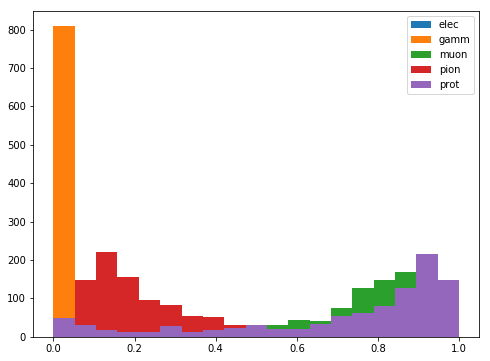

In [89]:
fig,ax=plt.subplots(1,1,figsize=(8,6))
bins=np.linspace(0,1,20)
ax.hist(scores[0], bins=bins, label="elec", stacked=1)
ax.hist(scores[1], bins=bins, label="gamm", stacked=1)
ax.hist(scores[2], bins=bins, label="muon", stacked=1)
ax.hist(scores[3], bins=bins, label="pion", stacked=1)
ax.hist(scores[4], bins=bins, label="prot", stacked=1)

ax.legend()
plt.show()